## Proyecto - Modelamiento de una serie de tiempo para predecir el consumo de transmisiones en camiones mineros 

Introduccion
El tren de potencia de un camion minero consta de varios componentes importantes que le permiten poder acarrear grandes cantidades de material esteril (tierra) o material mineral. Entre estos componentes se encuentra la servo transmision, la cual contiene un conjunto de embragues que asociados entre si dan lugar a las diferentes velocidades del equipo.
Este componente es un eslabon fragil del tren de potencia porque podria ser afectado por una mala operacion, por un deficiente mantenimiento o por una mala reconstruccion. Debido a esto es de gran analisis para el equipo de confiabilidad y de planeacion. 
Con base en esta informacion se requiere poder pronosticar cuanto sera el consumo de este componente en los proximos meses.
La informacion historica con la que se cuenta es el consumo mensual desde el año 2010.



In [1]:
pip install openpyxl --quiet


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

# Cargar el archivo Excel usando la ruta correcta
ruta_archivo = r'C:\Users\erodr\Downloads\Series de tiempo.xlsx'
df = pd.read_excel(ruta_archivo, sheet_name='Export Worksheet')

# Convertir la columna 'FECHA' a formato de fecha
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y%m%d')

# Extraer año y mes de la columna 'FECHA'
df['Year'] = df['FECHA'].dt.year
df['Month'] = df['FECHA'].dt.month

# Agrupar por Año y Mes para totalizar el consumo
consumo_mensual = df.groupby(['Year', 'Month']).size().reset_index(name='Consumption')

# Mostrar los primeros resultados del nuevo DataFrame
print(consumo_mensual)

# Guardar los resultados a un nuevo archivo Excel
consumo_mensual.to_excel('consumo_mensual.xlsx', index=False)


     Year  Month  Consumption
0    2010      9           12
1    2010     10            4
2    2010     11            5
3    2010     12            2
4    2011      2            3
..    ...    ...          ...
157  2024      5            8
158  2024      6           11
159  2024      7            4
160  2024      8            9
161  2024      9            4

[162 rows x 3 columns]


In [3]:
pip install statsmodels --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn --upgrade


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Iniciamos con el EDA de la serie que se requiere estudiar 

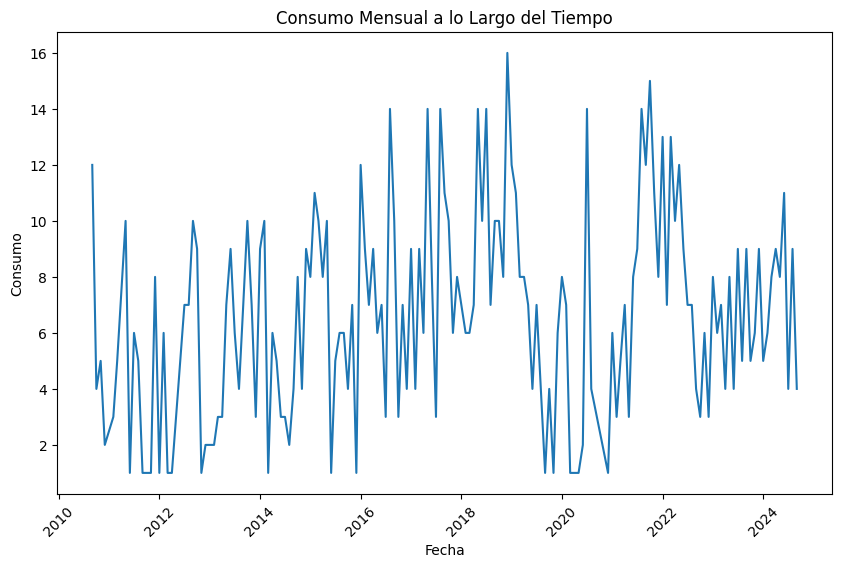

In [7]:
consumo_mensual['Date'] = pd.to_datetime(consumo_mensual[['Year', 'Month']].assign(DAY=1))

# Gráfico de líneas para observar la tendencia
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Consumption', data=consumo_mensual)
plt.title('Consumo Mensual a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.xticks(rotation=45)
plt.show()

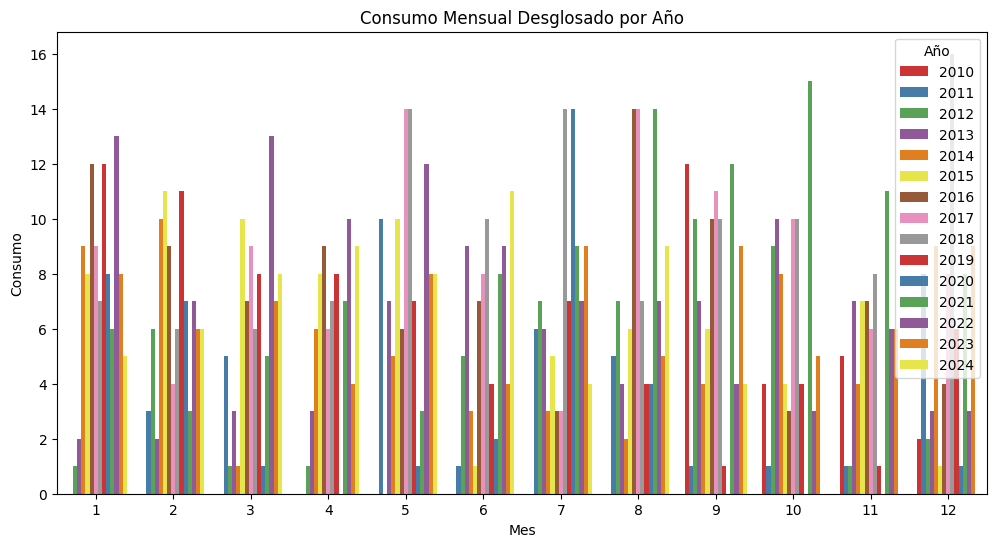

In [8]:
# Gráfico de barras agrupado por año y mes
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Consumption', hue='Year', data=consumo_mensual, palette='Set1')
plt.title('Consumo Mensual Desglosado por Año')
plt.xlabel('Mes')
plt.ylabel('Consumo')
plt.legend(title='Año', loc='upper right')
plt.show()

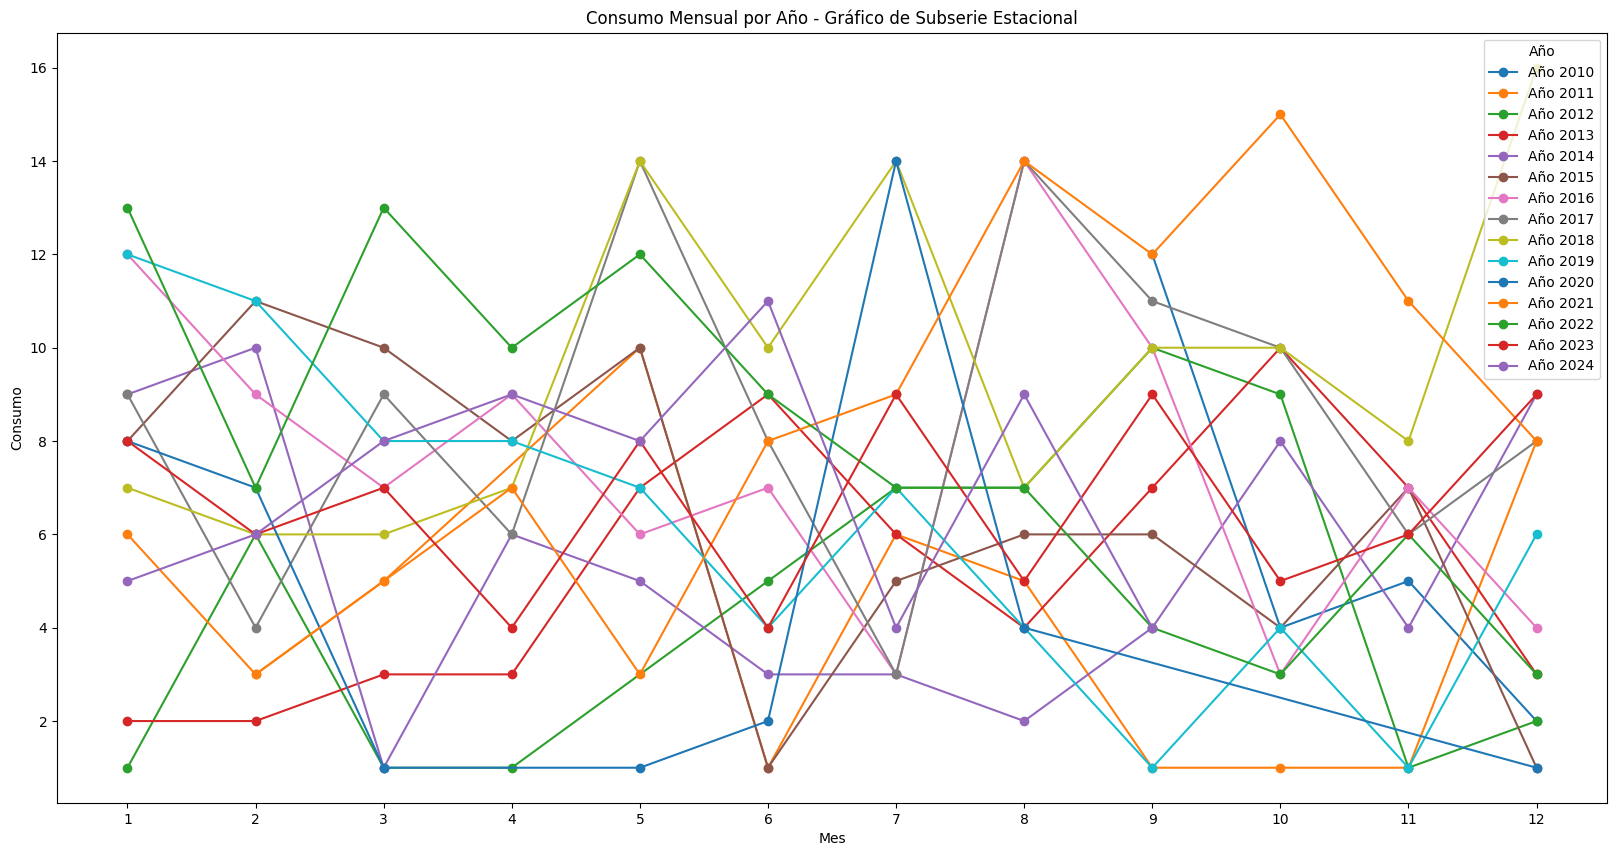

In [9]:
# Gráfico de líneas por cada año
plt.figure(figsize=(20, 10))
for year in consumo_mensual['Year'].unique():
    data = consumo_mensual[consumo_mensual['Year'] == year]
    plt.plot(data['Month'], data['Consumption'], marker='o', label=f'Año {year}')

plt.title('Consumo Mensual por Año - Gráfico de Subserie Estacional')
plt.xlabel('Mes')
plt.ylabel('Consumo')
plt.legend(title='Año', loc='upper right')
plt.xticks(ticks=range(1, 13))
plt.show()

Este gráfico muestra cómo varía el consumo en cada mes para diferentes años, permitiéndote identificar patrones estacionales.

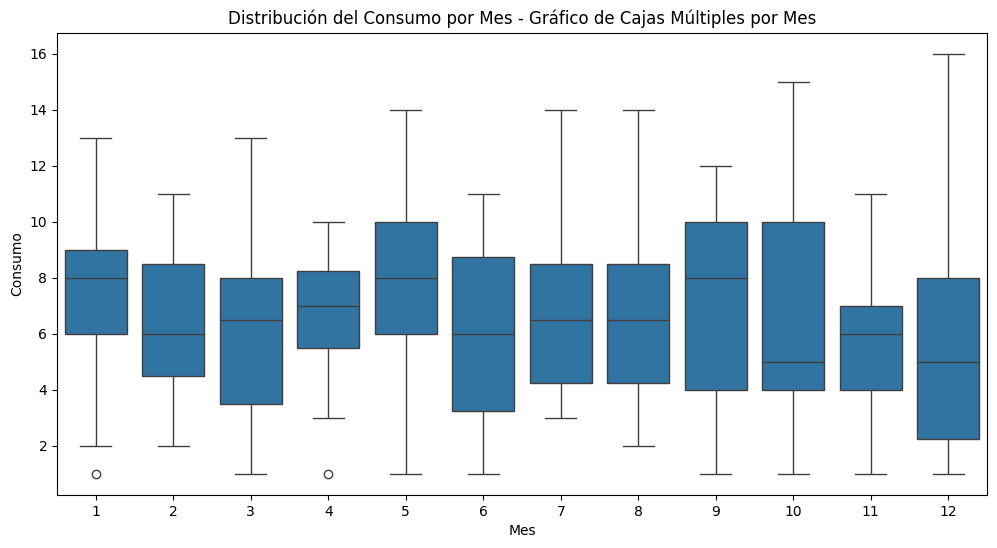

In [10]:
# Gráfico de caja para mostrar la distribución del consumo por mes
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Consumption', data=consumo_mensual)
plt.title('Distribución del Consumo por Mes - Gráfico de Cajas Múltiples por Mes')
plt.xlabel('Mes')
plt.ylabel('Consumo')
plt.show()

Este grafico permite visualizar la variabilidad y distribución del consumo para cada mes. Si los gráficos de cajas muestran variaciones significativas entre los meses, esto indica un componente estacional.

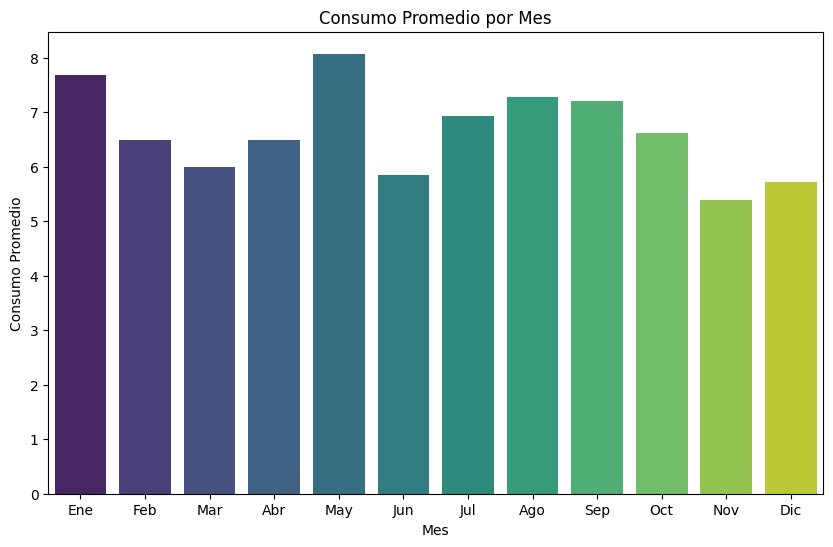

In [11]:
# Calcular el consumo promedio por mes
consumo_promedio_mensual = consumo_mensual.groupby('Month')['Consumption'].mean().reset_index()

# Gráfico de barras del consumo promedio por mes
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Consumption', data=consumo_promedio_mensual, palette='viridis')
plt.title('Consumo Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Consumo Promedio')
plt.xticks(ticks=range(0, 12), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.show()

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Test de Normalidad de los datos

In [13]:
from scipy.stats import shapiro, kstest

# Shapiro-Wilk Test
stat_shapiro, p_shapiro = shapiro(consumo_mensual['Consumption'])
alpha = 0.05
print('Shapiro-Wilk Test:')
print(f'Statistics={stat_shapiro:.6f}, p-value={p_shapiro:.6e}')
if p_shapiro > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

# Kolmogorov-Smirnov Test
stat_kstest, p_kstest = kstest(consumo_mensual['Consumption'], 'norm')
print('\nKolmogorov-Smirnov Test:')
print(f'Statistics={stat_kstest:.6f}, p-value={p_kstest:.6e}')
if p_kstest > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')


Shapiro-Wilk Test:
Statistics=0.967419, p-value=7.269453e-04
Sample does not look Normal (reject H0)

Kolmogorov-Smirnov Test:
Statistics=0.878484, p-value=1.325264e-148
Sample does not look Normal (reject H0)


Con los valores obtenidos en la pruebas anteriores podemos decir que la hipotesis nula se rechaza al tener valores de p-value por debajo de 0.05 y por ende no cumplen con el supuesto de normalidad.

D'Agostino K-squared Test:
Statistics=4.291423, p-value=1.169847e-01
Sample looks Normal (fail to reject H0)

Kurtosis of the original data: -0.471409

Kurtosis for each distribution:
Laplace Distribution: Kurtosis = 3.000000
Hyperbolic Secant Distribution: Kurtosis = 2.000000
Logistic Distribution: Kurtosis = 1.200000
Normal Distribution: Kurtosis = 0.000000
Cosine Distribution: Kurtosis = -0.593763
Semicircular Distribution: Kurtosis = -1.000000
Uniform Distribution: Kurtosis = -1.200000


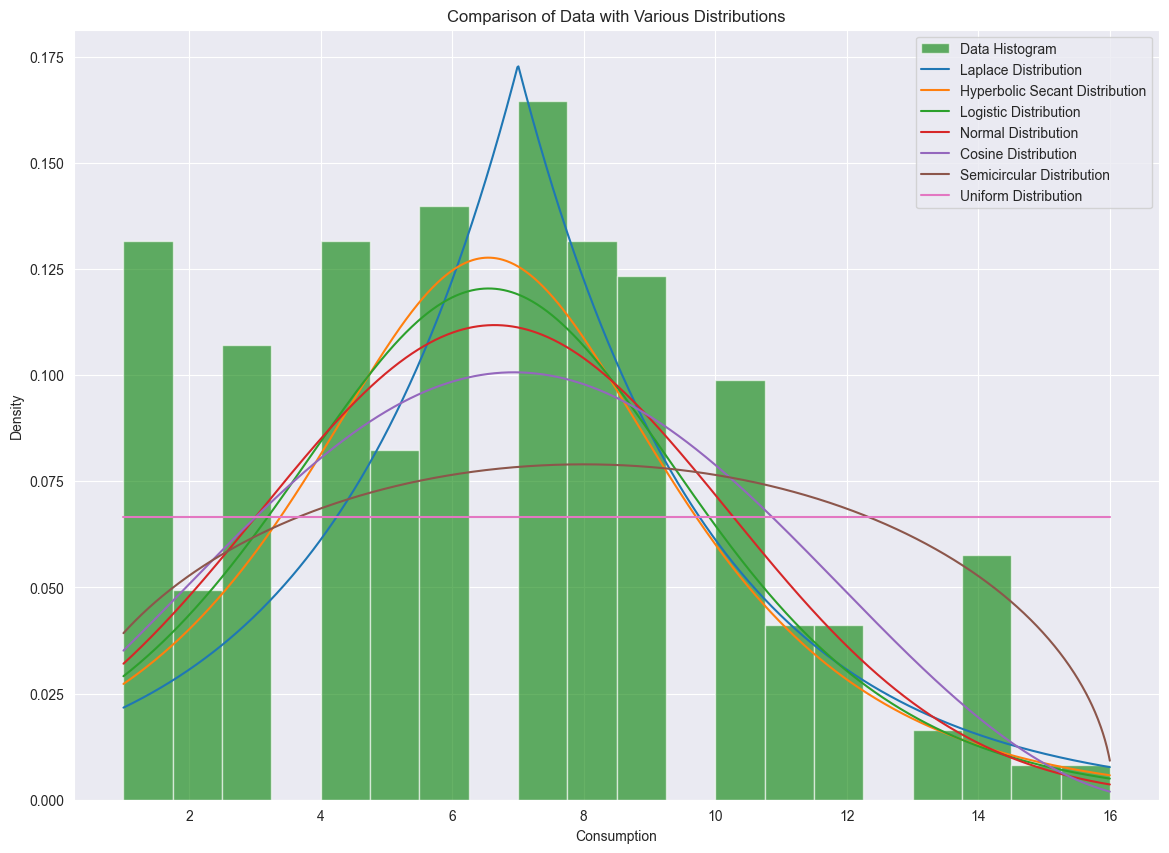

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, laplace, hypsecant, logistic, norm, cosine, semicircular, uniform, kurtosis



data = consumo_mensual['Consumption']

# Prueba de D'Agostino K2
stat, p_value = normaltest(data)
alpha = 0.05
print('D\'Agostino K-squared Test:')
print(f'Statistics={stat:.6f}, p-value={p_value:.6e}')
if p_value > alpha:
    print('Sample looks Normal (fail to reject H0)')
else:
    print('Sample does not look Normal (reject H0)')

# Calcular la curtosis de los datos originales
data_kurtosis = kurtosis(data)
print(f'\nKurtosis of the original data: {data_kurtosis:.6f}')

# Generar gráficos para comparar con diferentes distribuciones
distributions = {
    'Laplace': laplace,
    'Hyperbolic Secant': hypsecant,
    'Logistic': logistic,
    'Normal': norm,
    'Cosine': cosine,
    'Semicircular': semicircular,
    'Uniform': uniform
}

x = np.linspace(min(data), max(data), 1000)
plt.figure(figsize=(14, 10))

# Histograma de los datos
plt.hist(data, bins=20, density=True, alpha=0.6, color='g', label='Data Histogram')

# Calcular y mostrar la curtosis para cada distribución
print("\nKurtosis for each distribution:")
for dist_name, dist in distributions.items():
    # Ajustar la distribución a los datos
    params = dist.fit(data)
    # Calcular la curtosis teórica
    dist_kurtosis = dist(*params).stats(moments='k')
    print(f'{dist_name} Distribution: Kurtosis = {dist_kurtosis:.6f}')
    
    # Graficar la distribución
    pdf = dist.pdf(x, *params)
    plt.plot(x, pdf, label=f'{dist_name} Distribution')

plt.title('Comparison of Data with Various Distributions')
plt.xlabel('Consumption')
plt.ylabel('Density')
plt.legend()
plt.show()


Dado que la prueba de D'Agostino K-squared no rechaza la hipótesis nula de normalidad y que la curtosis de los datos originales está cercana a 0 (la curtosis de la distribución normal), se podria concluir erroneamente que los datos podrían ser modelados adecuadamente con una distribución normal, sin embargo al comparar con las pruebas de supuesto de Shapiro-Wilk y Kolmogorov-Smirnov las cuales sugieren que los datos no siguen una distribución normal, se podria concluir lo siguiente:
La prueba de D'Agostino K-squared se basa en la asimetría y la curtosis para evaluar la normalidad. Los datos pueden tener una forma general que se asemeja a una distribución normal en términos de sesgo y curtosis, lo que podría conducir a un resultado que "parezca" normal.
Las pruebas de Shapiro-Wilk y Kolmogorov-Smirnov son más sensibles a pequeñas desviaciones de la normalidad en la forma de los datos y pueden detectar irregularidades que el test de D'Agostino podría pasar por alto.
La curtosis negativa sugiere una distribución más plana con colas más delgadas que la normal. Aunque esto no implica necesariamente que los datos no sean normales, puede indicar que hay una ligera desviación que las pruebas de Shapiro-Wilk y Kolmogorov-Smirnov detectaron, mientras que el test de D'Agostino no lo hizo.
El tamaño de la muestra puede afectar la sensibilidad de las pruebas de normalidad. En muestras pequeñas, algunas pruebas pueden tener dificultades para detectar la verdadera naturaleza de la distribución. Las discrepancias entre las pruebas podrían deberse a cómo manejan la variabilidad en muestras más pequeñas. Shapiro-Wilk y Kolmogorov-Smirnov son generalmente más confiables para detectar la normalidad, especialmente en muestras más pequeñas, por lo tanto, es más prudente considerar que los datos no siguen una distribución normal.


## Validacion de datos faltantes

In [15]:
# Verificar si hay datos faltantes en el DataFrame `consumo_mensual`
missing_values_count = consumo_mensual.isna().sum()
missing_values_mean = consumo_mensual.isna().mean()

# Mostrar los resultados
print("Número de valores faltantes por columna:")
print(missing_values_count)

print("\nProporción de valores faltantes por columna:")
print(missing_values_mean)


Número de valores faltantes por columna:
Year           0
Month          0
Consumption    0
Date           0
dtype: int64

Proporción de valores faltantes por columna:
Year           0.0
Month          0.0
Consumption    0.0
Date           0.0
dtype: float64


No se tienen datos faltantes, por lo tanto continuamos con nuestro estudio.

## Generacion de la serie de tiempo

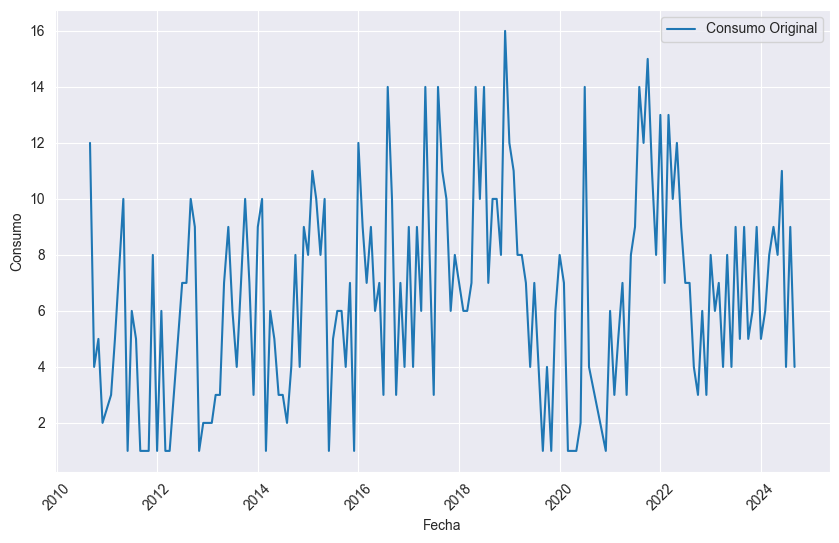

In [16]:
# Convertir la serie de consumo mensual a una serie de tiempo
consumo_ts = pd.Series(data=consumo_mensual['Consumption'].values, index=consumo_mensual['Date'])


# Graficar la serie original 
plt.figure(figsize=(10, 6))
plt.plot(consumo_ts, label='Consumo Original')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.xticks(rotation=45)
plt.show()

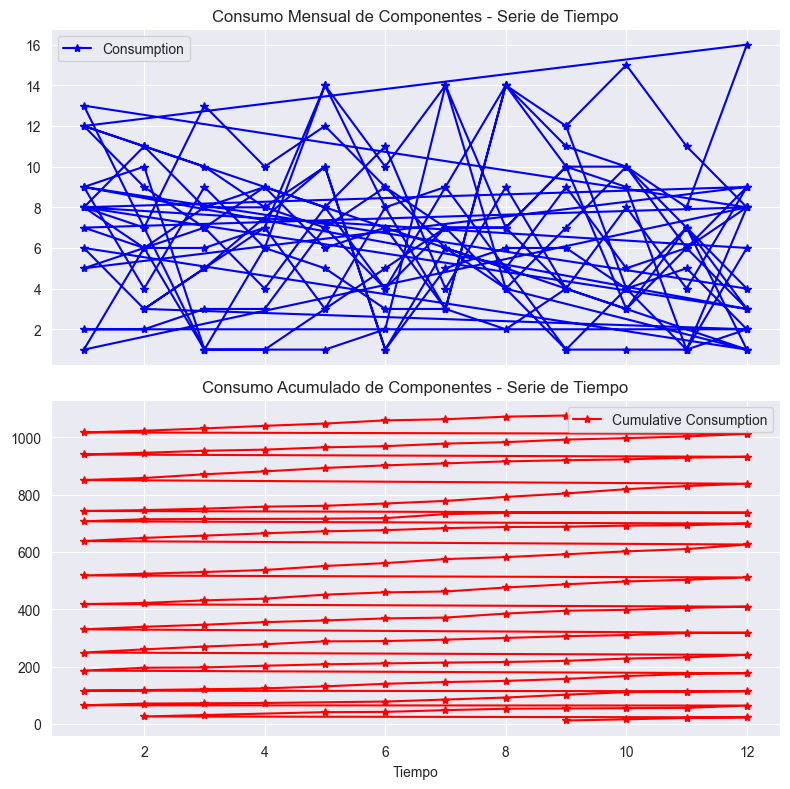

In [17]:
import matplotlib.pyplot as plt

# Generar la serie de tiempo tomando el consumo mensual de componentes
fig, axarr = plt.subplots(2, sharex=True)
fig.set_size_inches(8, 8)


axarr[0].set_title('Consumo Mensual de Componentes - Serie de Tiempo')
consumo_mensual.plot(x='Month', y='Consumption', linestyle='-', marker='*', color='b', ax=axarr[0])

# Consumo acumulado
axarr[1].set_title('Consumo Acumulado de Componentes - Serie de Tiempo')
consumo_mensual['Cumulative Consumption'] = consumo_mensual['Consumption'].cumsum()
consumo_mensual.plot(x='Month', y='Cumulative Consumption', linestyle='-', marker='*', color='r', ax=axarr[1])

plt.xlabel('Tiempo')
plt.tight_layout()
plt.show()


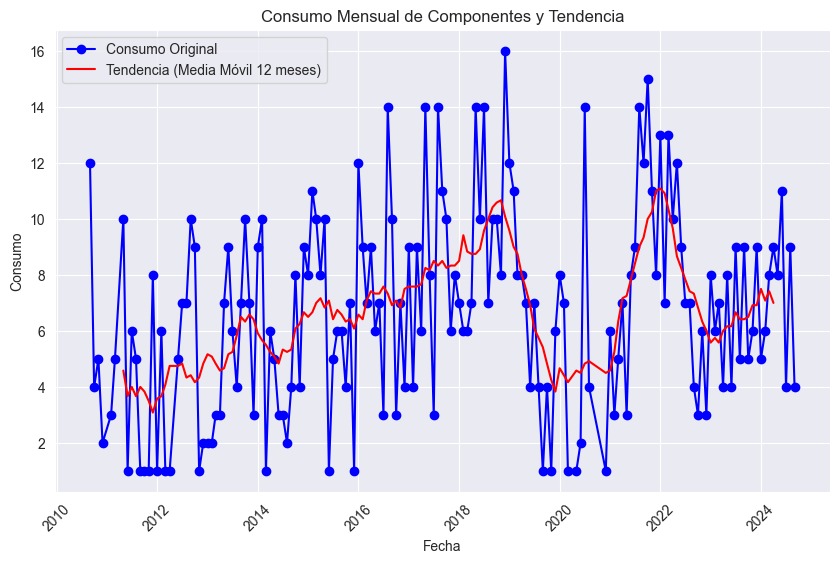

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la columna 'Year' y 'Month' a una columna de fecha y configurar como índice
consumo_mensual['Date'] = pd.to_datetime(consumo_mensual[['Year', 'Month']].assign(Day=1))
consumo_ts = pd.Series(data=consumo_mensual['Consumption'].values, index=consumo_mensual['Date'])

# Calcular la media móvil para mostrar la tendencia (por ejemplo, media móvil de 12 meses)
consumo_ts_trend = consumo_ts.rolling(window=12, center=True).mean()

# Graficar los datos originales y la tendencia
plt.figure(figsize=(10, 6))
plt.plot(consumo_ts, label='Consumo Original', linestyle='-', marker='o', color='b')
plt.plot(consumo_ts_trend, label='Tendencia (Media Móvil 12 meses)', linestyle='-', color='r')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Consumo Mensual de Componentes y Tendencia')
plt.legend()
plt.xticks(rotation=45)
plt.show()


## Se determinara a que modelo se ajustan nuestros datos: 
Modelos de Media Cero
Recorrido aleatorio
Modelos de tendencia
Modelos de estacionalidad

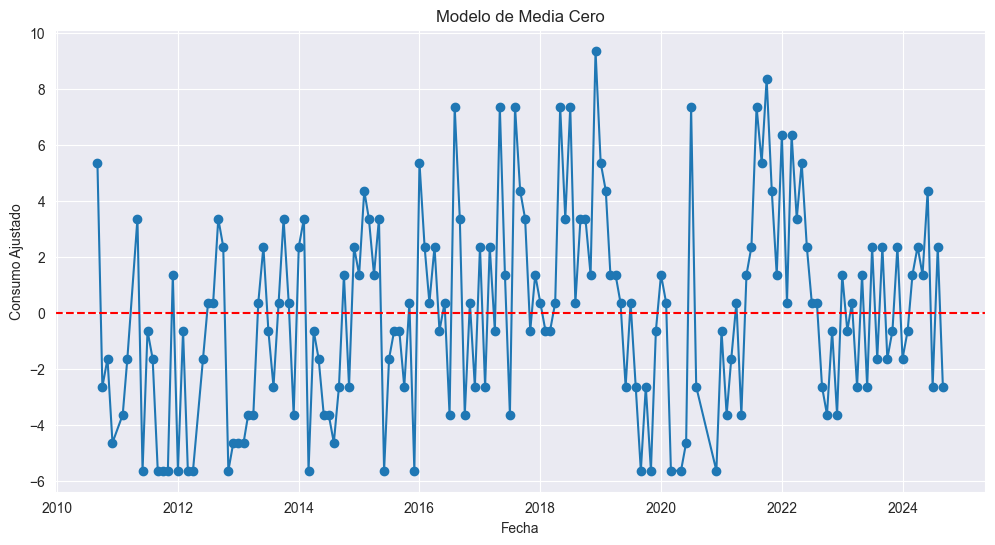

In [19]:
# Calcular la media de la serie
mean_consumption = consumo_ts.mean()

# Restar la media a la serie y graficar
zero_mean_series = consumo_ts - mean_consumption

plt.figure(figsize=(12, 6))
plt.plot(zero_mean_series, linestyle='-', marker='o')
plt.axhline(0, color='r', linestyle='--')
plt.title('Modelo de Media Cero')
plt.xlabel('Fecha')
plt.ylabel('Consumo Ajustado')
plt.show()


Se concluye con este grafico que nuestros datos no se ajustan a un modelo de media cero, ya que los datos no fluctúan alrededor de la línea roja en la gráfica

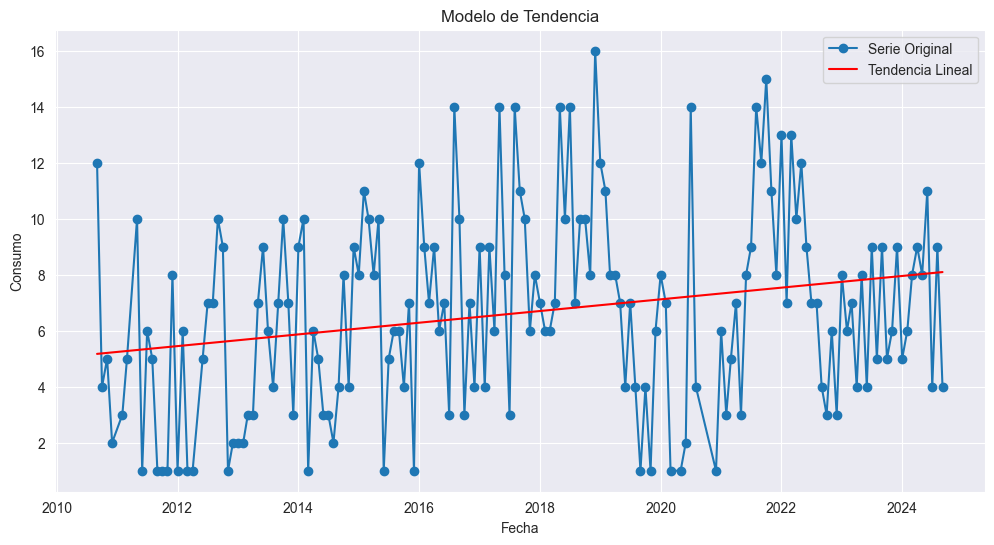

In [20]:

from scipy import stats
import matplotlib.pyplot as plt

# Convertir el índice de fecha a números (ejemplo: días desde la primera fecha)
consumo_ts_numeric_index = (consumo_ts.index - consumo_ts.index[0]).days

# Ajustar una línea de tendencia lineal
slope, intercept, r_value, p_value, std_err = stats.linregress(consumo_ts_numeric_index, consumo_ts.values)

# Crear la línea de tendencia
trend_line = intercept + slope * consumo_ts_numeric_index

# Graficar la serie original y la línea de tendencia
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts, label='Serie Original', linestyle='-', marker='o')
plt.plot(consumo_ts.index, trend_line, color='r', label='Tendencia Lineal')
plt.title('Modelo de Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()


Se finaliza el EDA y se procede con el paso 2 definido en el analisis de datos de series temporales



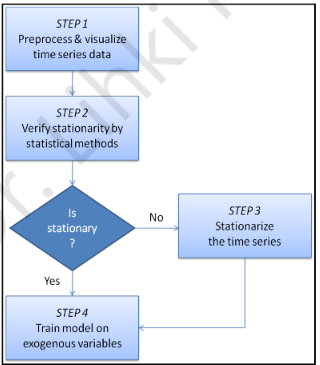

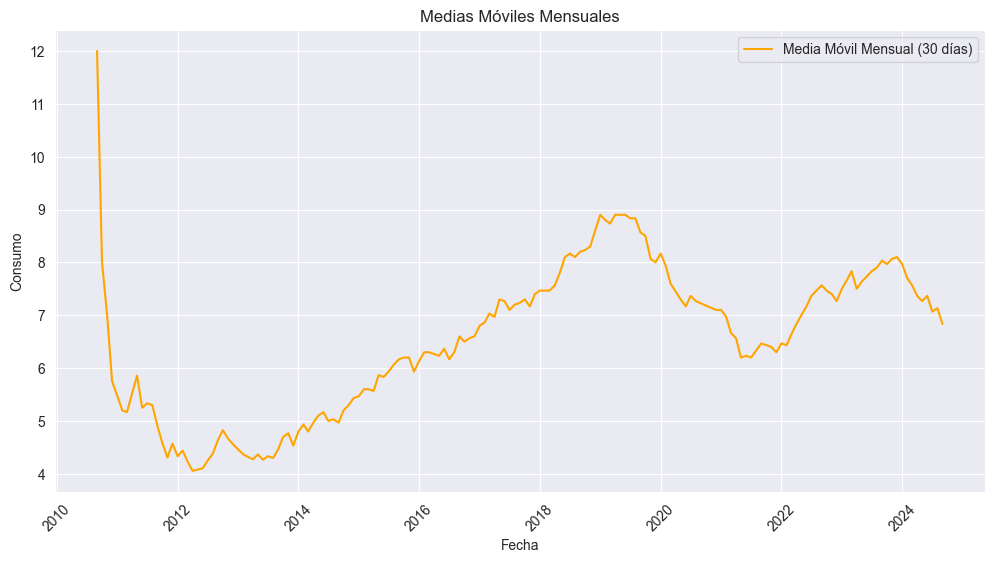

In [21]:
import matplotlib.pyplot as plt

# Calcular la media móvil mensual (ventana de 30 días)
consumo_ts_moving_avg_monthly = consumo_ts.rolling(window=30, min_periods=1).mean()

# Graficar solo la media móvil mensual
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts.index, consumo_ts_moving_avg_monthly, label='Media Móvil Mensual (30 días)', color='orange')
plt.title('Medias Móviles Mensuales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.xticks(rotation=45)
plt.show()



Este medida permite identificar tendencias, cambios significativos y estacionalidad.    

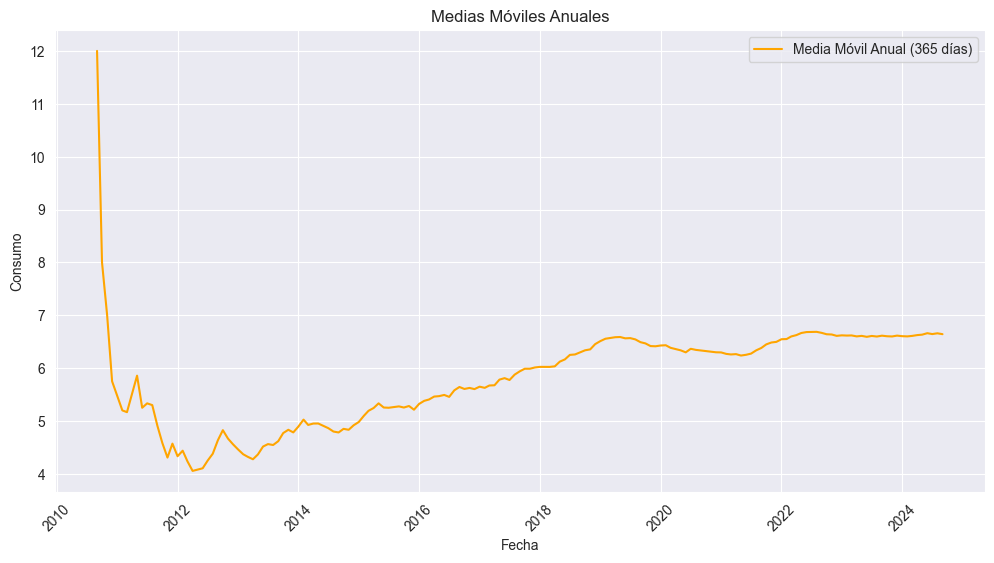

In [22]:
import matplotlib.pyplot as plt

# Calcular la media móvil anual (ventana de 365 días)
consumo_ts_moving_avg_annual = consumo_ts.rolling(window=365, min_periods=1).mean()

# Graficar solo la media móvil anual
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts.index, consumo_ts_moving_avg_annual, label='Media Móvil Anual (365 días)', color='orange')
plt.title('Medias Móviles Anuales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.xticks(rotation=45)
plt.show()


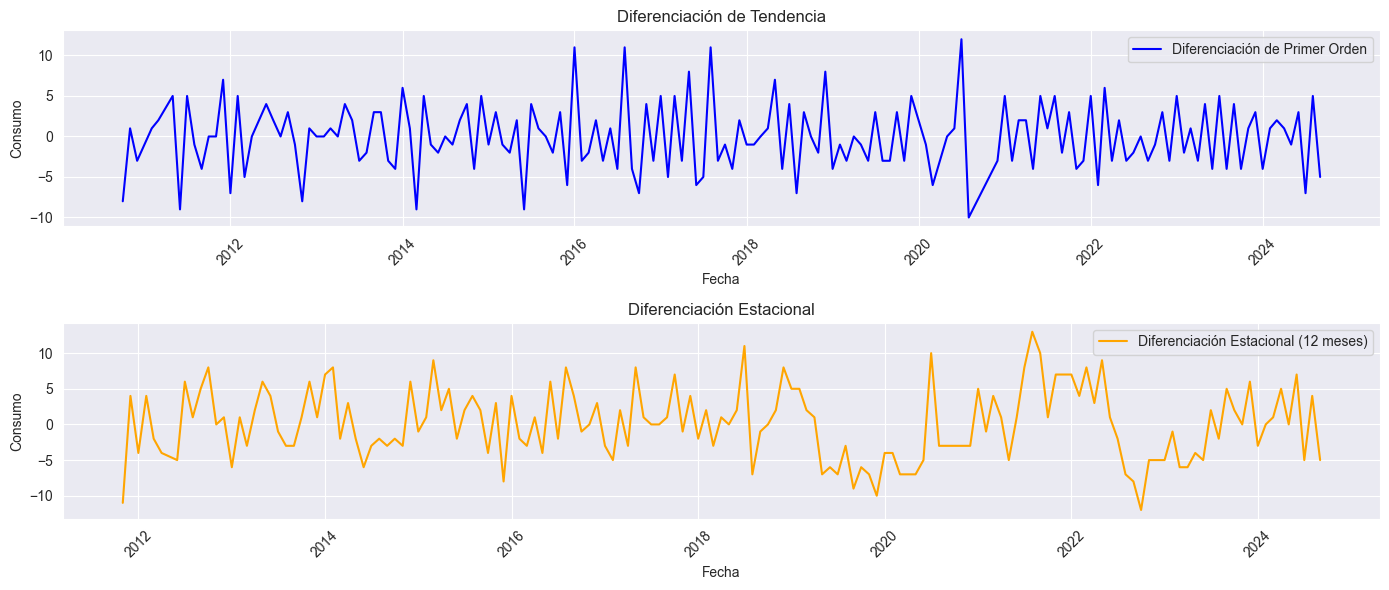

In [23]:
import matplotlib.pyplot as plt

# Diferenciación de primer orden (para eliminar tendencia)
consumo_diff_1 = consumo_ts.diff(periods=1).dropna()

# Diferenciación estacional (por ejemplo, anual: 12 meses)
consumo_diff_seasonal = consumo_ts.diff(periods=12).dropna()

# Graficar las series diferenciadas
plt.figure(figsize=(14, 6))

# Gráfico de la diferenciación de primer orden
plt.subplot(2, 1, 1)
plt.plot(consumo_diff_1, label='Diferenciación de Primer Orden', color='blue')
plt.title('Diferenciación de Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.xticks(rotation=45)

# Gráfico de la diferenciación estacional
plt.subplot(2, 1, 2)
plt.plot(consumo_diff_seasonal, label='Diferenciación Estacional (12 meses)', color='orange')
plt.title('Diferenciación Estacional')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Validacion de estacionalidad de la serie

A traves de la prueba ADF se valida esatacionalidad 

In [24]:
from statsmodels.tsa.stattools import adfuller

# Aplicar la Prueba de Dickey-Fuller Aumentada
result = adfuller(consumo_ts)

# Extraer e imprimir los resultados
print('Resultados de la Prueba de Dickey-Fuller Aumentada:')
print(f'Estadístico ADF: {result[0]:.4f}')
print(f'Valor p: {result[1]:.4f}')
print(f'Número de retardos utilizados: {result[2]}')
print(f'Número de observaciones: {result[3]}')
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value:.4f}')

# Interpretar el resultado
if result[1] < 0.05:
    print("\nLa serie es estacionaria (rechazamos la hipótesis nula).")
else:
    print("\nLa serie no es estacionaria (no se puede rechazar la hipótesis nula).")


Resultados de la Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: -5.6646
Valor p: 0.0000
Número de retardos utilizados: 1
Número de observaciones: 160
Valores críticos:
   1%: -3.4719
   5%: -2.8798
   10%: -2.5765

La serie es estacionaria (rechazamos la hipótesis nula).


## Descomposicion de mi serie 

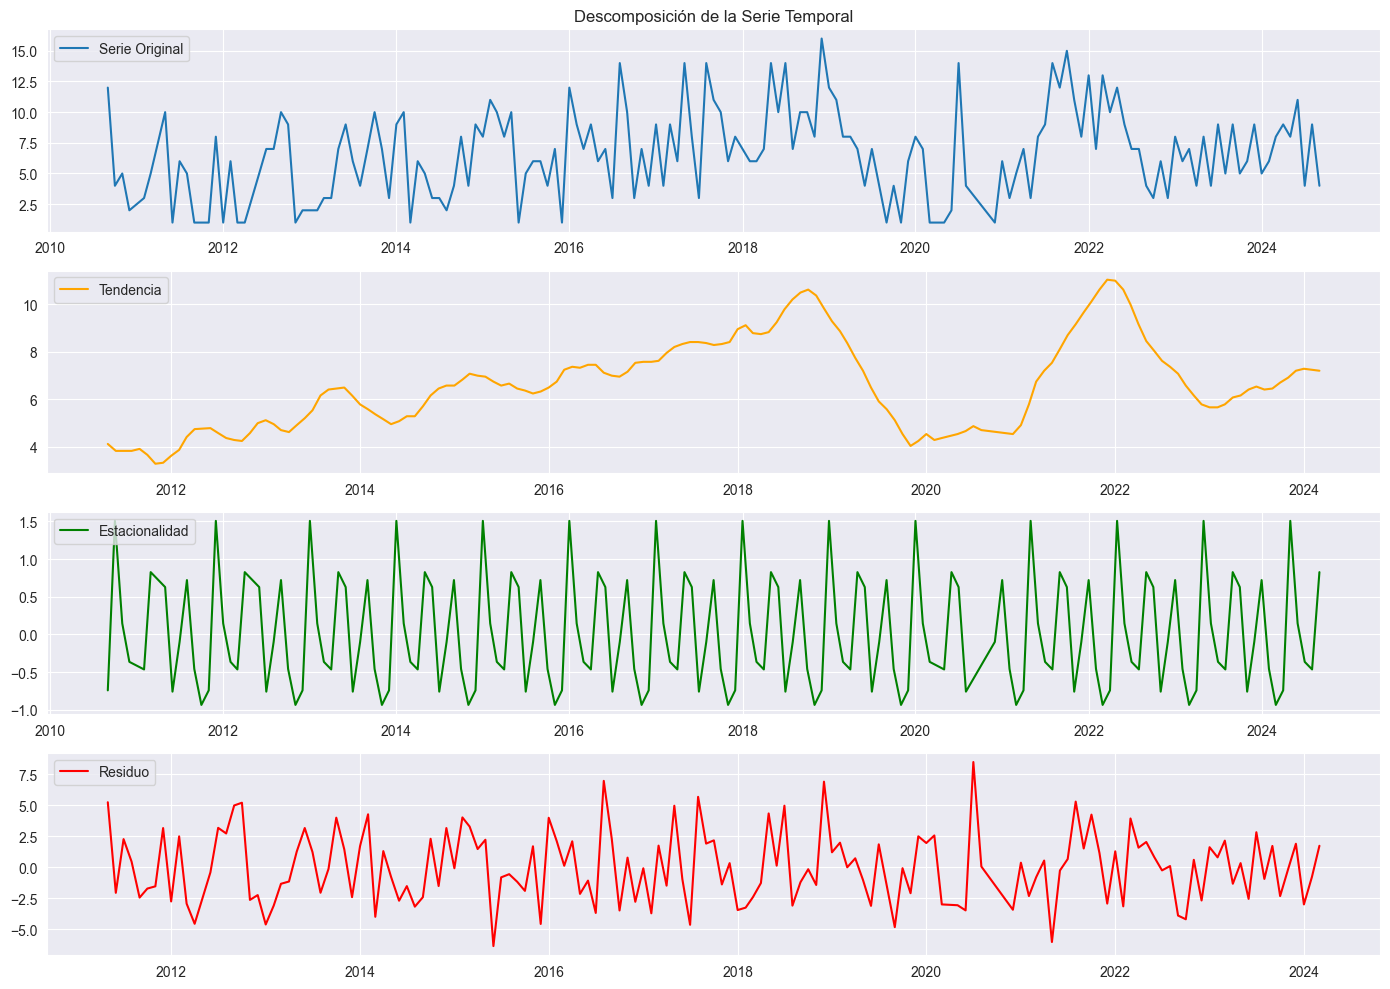

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomponer la serie de tiempo (suponiendo frecuencia mensual)
decomposition = seasonal_decompose(consumo_ts, model='additive', period=12)

# Extraer los componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Graficar los componentes
plt.figure(figsize=(14, 10))

# Serie original
plt.subplot(4, 1, 1)
plt.plot(consumo_ts, label='Serie Original')
plt.title('Descomposición de la Serie Temporal')
plt.legend(loc='upper left')

# Tendencia
plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendencia', color='orange')
plt.legend(loc='upper left')

# Estacionalidad
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend(loc='upper left')

# Residuo
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuo', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


La descomposición es crucial para entender las características internas de la serie de tiempo. Al separar la tendencia, la estacionalidad y el residuo, se facilita la construcción de modelos predictivos, como modelos ARIMA o SARIMA.
También es útil para evaluar la estacionalidad de forma más clara, ya que muestra los patrones repetitivos en un gráfico separado.

Interpretación
Serie Original: Muestra los datos brutos tal como se registraron.

Tendencia: Visualiza el movimiento a largo plazo en los datos, lo que permite observar si hay una subida, bajada o cambios en la dirección general.

Estacionalidad: Muestra los patrones repetitivos que ocurren en intervalos regulares. Esto te ayuda a identificar ciclos que ocurren cada año, mes, semana, etc.

Residuo: Lo que queda después de eliminar la tendencia y la estacionalidad. Si los residuos parecen ruido blanco (fluctúan alrededor de cero sin patrón), el modelo de descomposición es apropiado.

## Suavizacion exponencial

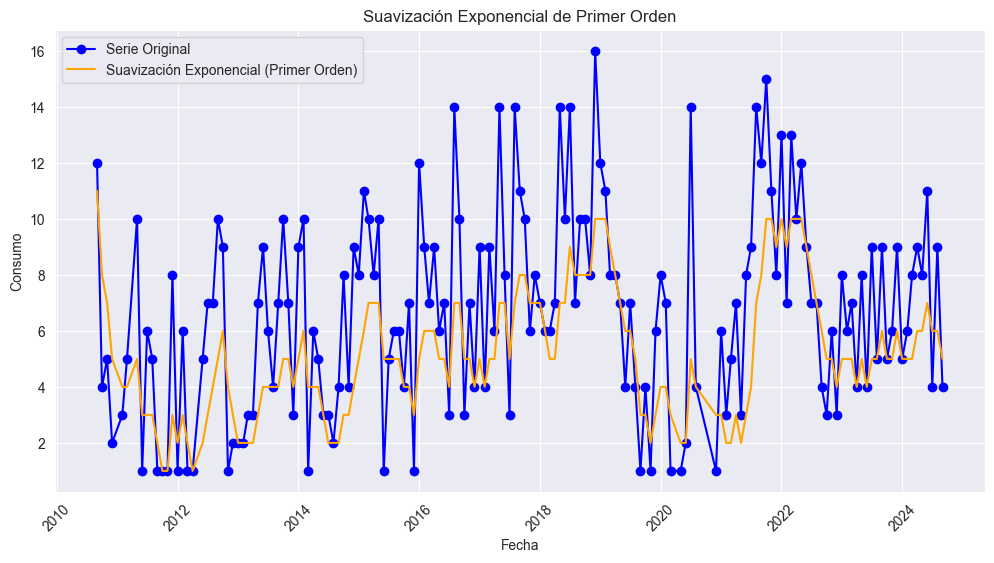

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Función de suavización exponencial de primer orden
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

# Parámetro de suavización (lambda), valor entre 0 y 1
lambda_ = 0.3

# Aplicar la suavización exponencial de primer orden a la serie de tiempo
smoothed_series = firstsmooth(consumo_ts.values, lambda_)

# Graficar la serie original y la serie suavizada
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts.index, consumo_ts.values, label='Serie Original', linestyle='-', marker='o', color='blue')
plt.plot(consumo_ts.index, smoothed_series, label='Suavización Exponencial (Primer Orden)', linestyle='-', color='orange')
plt.title('Suavización Exponencial de Primer Orden')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.xticks(rotation=45)
plt.show()


La suavización exponencial es una técnica de modelado de series temporales que se utiliza para reducir el "ruido" en los datos y resaltar patrones importantes como la tendencia y la estacionalidad. La suavización es especialmente útil en escenarios donde los datos tienen variaciones bruscas y a corto plazo que pueden dificultar la identificación de patrones más generales.
Objetivos de la Suavización Exponencial:
Eliminar Fluctuaciones a Corto Plazo: Reduce las variaciones bruscas (ruido) en los datos, lo que permite ver la tendencia general de la serie.
Resaltar Patrones: Facilita la identificación de patrones importantes como la tendencia y la estacionalidad, que son clave para el análisis y predicción.
Predicción: La suavización exponencial es un componente básico de muchos métodos de pronóstico (como el modelo ETS - Error, Trend, Seasonality) y sirve para generar pronósticos basados en la información más reciente de la serie.


In [27]:
import pandas as pd

# Función de suavización exponencial de primer orden
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return pd.Series(ytilde)

# Función para calcular las métricas de precisión: MAPE, MAD y MSD
def measacc_fs(y, lambda_):
    smoothed_series = firstsmooth(y, lambda_)
    T = len(y)
    
    # Obtener los valores reales y los valores suavizados (predicciones)
    yh = y.copy()
    predictions = pd.concat([pd.Series([y.iloc[0]]), smoothed_series.iloc[:-1]], ignore_index=True)
    
    # Calcular los errores de predicción
    prederr = yh.values - predictions.values
    
    # Calcular las métricas
    SSE = sum(prederr ** 2)
    MAPE = 100 * sum(abs(prederr / yh.values)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr ** 2) / T
    
    # Retornar las métricas en un DataFrame
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

# Aplicar la función a la serie de tiempo
lambda_ = 0.3  # Puedes ajustar el valor de lambda según tu análisis anterior
precision_metrics = measacc_fs(consumo_ts, lambda_)
print(precision_metrics)


         SSE       MAPE       MAD       MSD
0  1926.7924  83.569205  2.777291  11.89378


MAPE mide el error promedio entre los valores reales y los valores suavizados como un porcentaje del valor real.
Un MAPE del 83.57% indica que, en promedio, los valores suavizados están desviados de los valores reales en un 83.57%. Esto sugiere que el modelo de suavización no es muy preciso. En general, un MAPE inferior al 10% se considera excelente, mientras que un MAPE superior al 50% indica un ajuste deficiente.
λ seleccionado en este caso, 0.3 no está capturando correctamente el patrón de los datos.
MAD mide la magnitud media de los errores entre los valores reales y los suavizados en las mismas unidades que los datos originales.
Interpretación: Un MAD de 2.777 significa que, en promedio, los errores absolutos entre los valores reales y los valores suavizados son aproximadamente 2.777 unidades. Esto proporciona una medida directa de cuánto se desvían los valores suavizados de los valores reales.
Al igual que SSE, el valor de MAD es más útil cuando se compara con otros modelos o diferentes valores de 𝜆
MSD es el promedio de los errores al cuadrado. Al elevar los errores al cuadrado, la MSD da más peso a los errores grandes, lo que la hace útil para evaluar modelos que deben minimizar errores extremos.
Un MSD de 11.8938 indica una cantidad significativa de error promedio al cuadrado en los datos suavizados. Al igual que SSE y MAD, es más significativo cuando se compara con otros modelos para ver cuál minimiza el error.


In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Función para calcular las métricas de precisión usando Exponential Smoothing
def measacc_hw(y, lambda_):
    # Aplicar el modelo de suavización exponencial
    model = ExponentialSmoothing(y.values)
    fit = model.fit(smoothing_level=lambda_)
    
    T = len(y)
    yh = y.copy().values
    
    # Obtener los valores ajustados (suavizados)
    y_pred = pd.Series(data=fit.fittedvalues, index=y.index)
    
    # Concatenar los valores suavizados para calcular errores
    out = pd.concat([pd.Series([y.iloc[0]]), y_pred[:-1]], ignore_index=True).values
    prederr = yh - out  # Errores de predicción
    
    # Calcular las métricas de precisión
    SSE = sum(prederr ** 2)
    MAPE = 100 * sum(abs(prederr / yh)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr ** 2) / T
    
    # Retornar las métricas en un DataFrame
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

# Aplicar la función a los datos de consumo mensual con un lambda de 0.3
lambda_ = 0.3
precision_metrics_hw = measacc_hw(consumo_ts, lambda_)
print(precision_metrics_hw)


           SSE       MAPE      MAD        MSD
0  1955.894229  84.043087  2.87123  12.073421


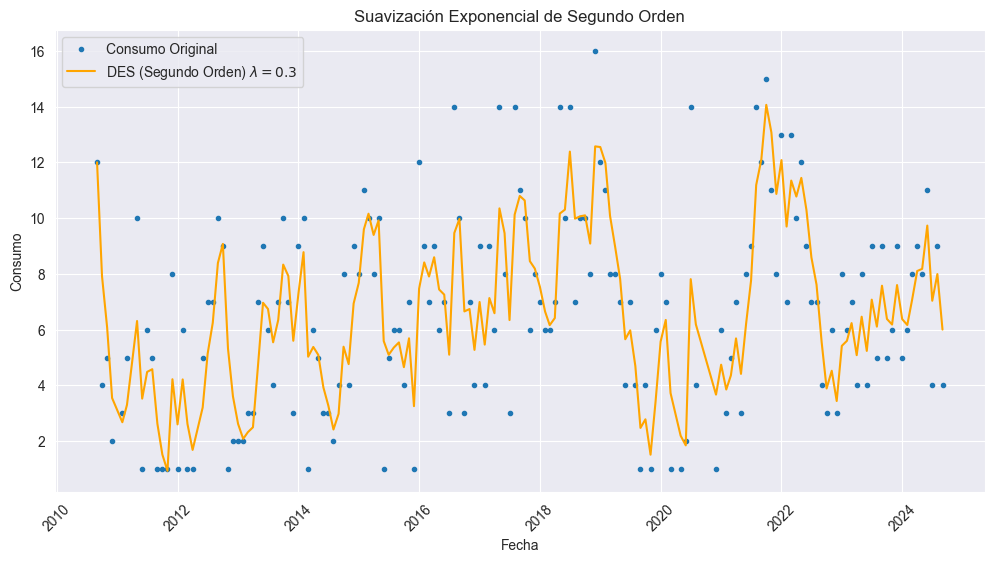

In [29]:
import matplotlib.pyplot as plt

# Función de suavización exponencial de primer orden
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return pd.Series(ytilde, index=y.index)

# Aplicar suavización exponencial de primer orden dos veces para obtener la suavización de segundo orden
lambda_ = 0.3
cpi_smooth1 = firstsmooth(y=consumo_ts, lambda_=lambda_)
cpi_smooth2 = firstsmooth(y=cpi_smooth1, lambda_=lambda_)

# Calcular la serie suavizada final (segundo orden)
cpi_hat = 2 * cpi_smooth1 - cpi_smooth2

# Graficar la serie original y la suavización exponencial de segundo orden
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts, marker='o', linestyle='', markersize=3, label='Consumo Original')
plt.plot(cpi_hat, label=f'DES (Segundo Orden) $\lambda={lambda_}$', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.title('Suavización Exponencial de Segundo Orden')
plt.xticks(rotation=45)
plt.show()


In [30]:
import pandas as pd

# Función para calcular las métricas de precisión: SSE, MAPE, MAD, MSD para la suavización exponencial de segundo orden
def measacc_second_order(y, lambda_):
    # Aplicar suavización de segundo orden
    smooth1 = firstsmooth(y, lambda_)
    smooth2 = firstsmooth(smooth1, lambda_)
    y_hat = 2 * smooth1 - smooth2
    
    T = len(y)
    yh = y.copy().values
    
    # Ajustar los valores suavizados para calcular errores
    out = pd.concat([pd.Series([y.iloc[0]]), y_hat.iloc[:-1]], ignore_index=True).values
    prederr = yh - out  # Errores de predicción
    
    # Calcular las métricas de precisión
    SSE = sum(prederr ** 2)
    MAPE = 100 * sum(abs(prederr / yh)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr ** 2) / T
    
    # Retornar las métricas en un DataFrame
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

# Calcular las métricas para la suavización exponencial de segundo orden
lambda_ = 0.3
metrics_second_order = measacc_second_order(consumo_ts, lambda_)
print(metrics_second_order)


           SSE       MAPE     MAD        MSD
0  2082.964312  81.527803  2.8377  12.857804


MAPE obtenido aquí es 81.53%, que sigue siendo muy alto. Aunque es ligeramente menor que el MAPE de la suavización de primer orden (83.57%), sigue indicando un ajuste deficiente. Un MAPE tan alto significa que, en promedio, las predicciones se desvían del valor real en un 81.53%, lo que indica que el modelo no es preciso.
El valor de MAD es 2.8377, lo cual es un poco más bajo que el valor obtenido con la suavización de primer orden (2.8748). Esto indica que, en promedio, la suavización de segundo orden reduce ligeramente la magnitud del error, aunque la mejora es mínima
La MSD es 12.86, que es ligeramente más alta que la MSD obtenida con la suavización de primer orden (12.37). Esto implica que el modelo de segundo orden no está mejorando en la captura de las fluctuaciones de los datos y, de hecho, puede estar presentando errores más significativos.

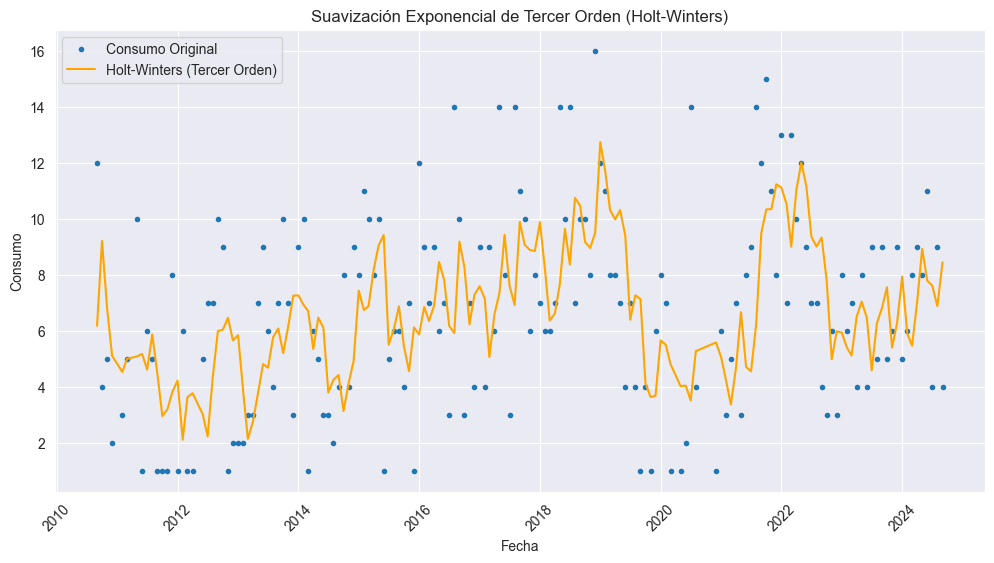

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Aplicar suavización exponencial de tercer orden (Holt-Winters) con estacionalidad aditiva
lambda_ = 0.3  # Parámetro de nivel de suavización
model = ExponentialSmoothing(consumo_ts, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit(smoothing_level=lambda_)

# Obtener la serie suavizada
consumo_hat_hw = fit.fittedvalues

# Graficar la serie original y la suavización exponencial de tercer orden (Holt-Winters)
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts, marker='o', linestyle='', markersize=3, label='Consumo Original')
plt.plot(consumo_hat_hw, label='Holt-Winters (Tercer Orden)', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.title('Suavización Exponencial de Tercer Orden (Holt-Winters)')
plt.xticks(rotation=45)
plt.show()


In [32]:

# Función para calcular las métricas de precisión: SSE, MAPE, MAD, MSD para la suavización exponencial de tercer orden (Holt-Winters)
def measacc_holt_winters(y, fit):
    T = len(y)
    yh = y.copy().values
    
    # Obtener los valores suavizados (fittedvalues)
    y_hat = pd.Series(data=fit.fittedvalues, index=y.index)
    
    # Ajustar los valores suavizados para calcular errores
    out = pd.concat([pd.Series([y.iloc[0]]), y_hat.iloc[:-1]], ignore_index=True).values
    prederr = yh - out  # Errores de predicción
    
    # Calcular las métricas de precisión
    SSE = sum(prederr ** 2)
    MAPE = 100 * sum(abs(prederr / yh)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr ** 2) / T
    
    # Retornar las métricas en un DataFrame
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

# Calcular las métricas para la suavización de tercer orden (Holt-Winters)
metrics_holt_winters = measacc_holt_winters(consumo_ts, fit)
print(metrics_holt_winters)



           SSE       MAPE       MAD        MSD
0  1968.476327  82.777039  2.872426  12.151088


El valor del MAPE es 82.78%, lo que indica que las predicciones se desvían del valor real en un 82.78%, en promedio. Este valor es ligeramente menor que los obtenidos en las suavizaciones de primer (83.57%) y segundo orden (81.53%). Sin embargo, sigue siendo muy alto para considerarse un buen ajuste (un MAPE por debajo del 10% se considera excelente).
El valor de MAD es 2.87, muy similar a los valores obtenidos con las suavizaciones anteriores (primer y segundo orden). Esto sugiere que, en promedio, el error absoluto entre los valores reales y los suavizados se ha mantenido constante, lo que indica que la mejora en el ajuste es mínima.
La MSD es 12.15, que es más baja que la de las suavizaciones de primer (12.37) y segundo orden (12.86). Esto muestra que el modelo de tercer orden (Holt-Winters) ha logrado reducir los errores más significativos, aunque la mejora es leve.

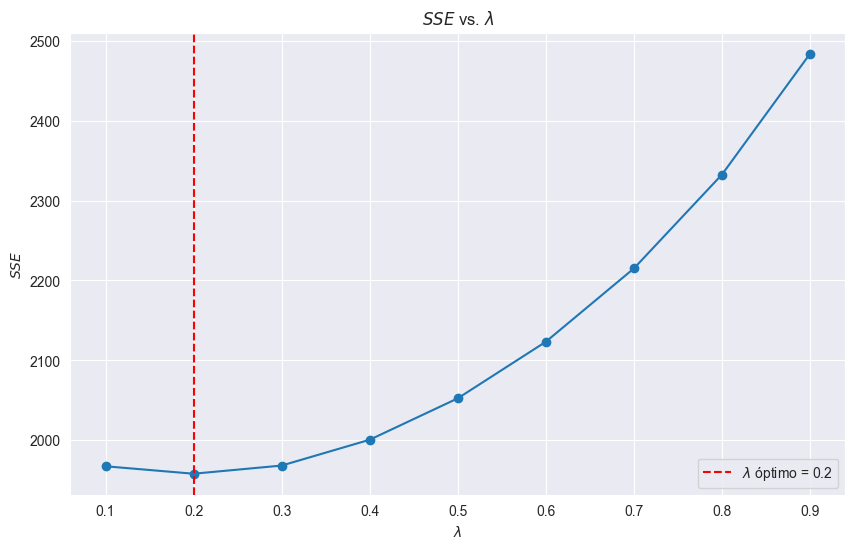

El valor óptimo de lambda es: 0.2


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Función para calcular el SSE utilizando la suavización de tercer orden (Holt-Winters)
def sse_holt_winters(lambda_):
    model = ExponentialSmoothing(consumo_ts, trend='add', seasonal='add', seasonal_periods=12)
    fit = model.fit(smoothing_level=lambda_)
    sse = measacc_holt_winters(consumo_ts, fit)['SSE'].values[0]
    return sse

# Vector de valores lambda para probar
lambda_vec = np.arange(0.1, 1.0, 0.1)

# Calcular el SSE para cada valor de lambda
sse_vec = pd.Series()
for lambda_ in lambda_vec:
    sse_vec.loc[len(sse_vec)] = sse_holt_winters(lambda_)

# Encontrar el valor óptimo de lambda
opt_lambda = lambda_vec[sse_vec.idxmin()]

# Graficar SSE vs. lambda
plt.figure(figsize=(10, 6))
plt.plot(lambda_vec, sse_vec, marker='o', linestyle='-')
plt.title('$SSE$ vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('$SSE$')
plt.axvline(x=opt_lambda, color='red', linestyle='--', label=f'$\lambda$ óptimo = {opt_lambda:.1f}')
plt.legend()
plt.show()

print(f'El valor óptimo de lambda es: {opt_lambda:.1f}')


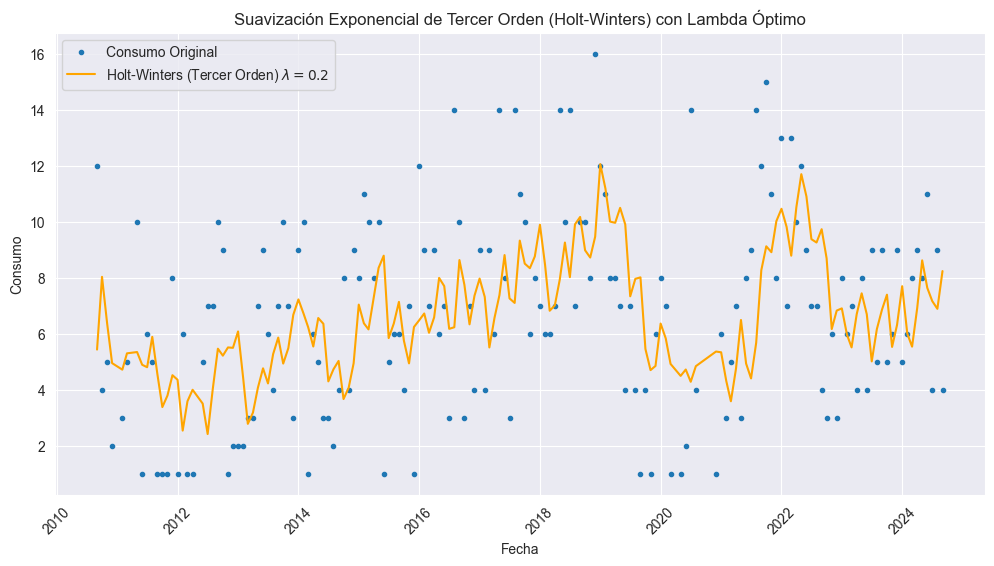

           SSE       MAPE       MAD        MSD
0  1958.267448  83.730022  2.855451  12.088071


In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Aplicar suavización exponencial de tercer orden (Holt-Winters) con el nuevo valor óptimo de lambda = 0.2
lambda_opt = 0.2  # Nuevo valor óptimo de lambda
model_opt = ExponentialSmoothing(consumo_ts, trend='add', seasonal='add', seasonal_periods=12)
fit_opt = model_opt.fit(smoothing_level=lambda_opt)

# Obtener la serie suavizada con el nuevo valor de lambda
consumo_hat_hw_opt = fit_opt.fittedvalues

# Graficar la serie original y la suavización exponencial de tercer orden (Holt-Winters) con el nuevo lambda
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts, marker='o', linestyle='', markersize=3, label='Consumo Original')
plt.plot(consumo_hat_hw_opt, label=f'Holt-Winters (Tercer Orden) $\lambda={lambda_opt}$', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.title('Suavización Exponencial de Tercer Orden (Holt-Winters) con Lambda Óptimo')
plt.xticks(rotation=45)
plt.show()

# Calcular las métricas para la suavización de tercer orden (Holt-Winters) con el nuevo lambda
metrics_holt_winters_opt = measacc_holt_winters(consumo_ts, fit_opt)
print(metrics_holt_winters_opt)



Al ajustar el valor de 𝜆 a 0.2, observamos solo mejoras marginales en algunas métricas (SSE y MSD) y un ligero empeoramiento en el MAPE. Esto indica que el modelo Holt-Winters con suavización exponencial no está logrando capturar los patrones de la serie temporal de manera significativa.
El MAPE sigue siendo extremadamente alto (83.73%), lo que señala que el modelo no es adecuado para predecir los datos con precisión. La persistencia de errores altos sugiere que hay componentes o comportamientos en la serie que la suavización exponencial no puede modelar correctamente.

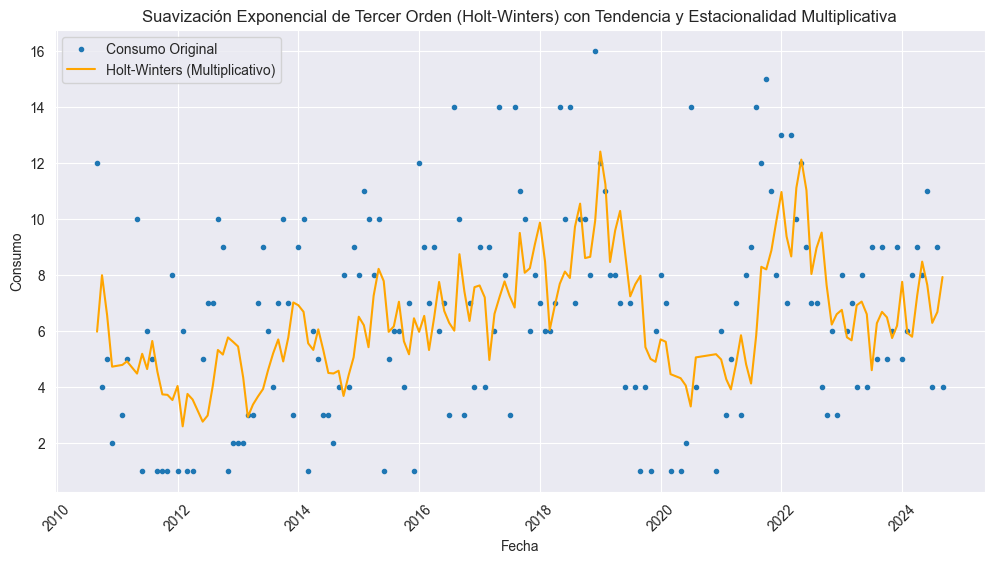

           SSE       MAPE       MAD        MSD
0  1943.318971  81.349113  2.837686  11.995796


In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Aplicar suavización exponencial de tercer orden (Holt-Winters) con tendencia multiplicativa y estacionalidad multiplicativa
model_multiplicative = ExponentialSmoothing(consumo_ts, trend='mul', seasonal='mul', seasonal_periods=12)
fit_multiplicative = model_multiplicative.fit(smoothing_level=lambda_opt)

# Obtener la serie suavizada con el nuevo ajuste
consumo_hat_hw_multiplicative = fit_multiplicative.fittedvalues

# Graficar la serie original y la suavización exponencial de tercer orden (Holt-Winters) con tendencia y estacionalidad multiplicativa
plt.figure(figsize=(12, 6))
plt.plot(consumo_ts, marker='o', linestyle='', markersize=3, label='Consumo Original')
plt.plot(consumo_hat_hw_multiplicative, label='Holt-Winters (Multiplicativo)', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.title('Suavización Exponencial de Tercer Orden (Holt-Winters) con Tendencia y Estacionalidad Multiplicativa')
plt.xticks(rotation=45)
plt.show()

# Calcular las métricas para la suavización de tercer orden (Holt-Winters) con tendencia y estacionalidad multiplicativa
metrics_holt_winters_multiplicative = measacc_holt_winters(consumo_ts, fit_multiplicative)
print(metrics_holt_winters_multiplicative)


La suavización exponencial de tercer orden (Holt-Winters) con tendencia y estacionalidad multiplicativa ha mostrado una ligera mejora en todas las métricas (SSE, MAPE, MAD, y MSD) en comparación con las configuraciones aditivas. Esto sugiere que el componente multiplicativo es más adecuado para la estructura de los datos, ya que captura mejor la variabilidad proporcional.
A pesar de la mejora, el MAPE sigue siendo muy alto (81.35%), lo que indica que el modelo todavía no es adecuado para una predicción precisa. La presencia de errores significativos sugiere que los datos tienen características más complejas, como estacionalidad cambiante, patrones no lineales, o presencia de ruido que la suavización exponencial no puede modelar completamente.




El modelo Holt-Winters con componentes multiplicativos ha mostrado una mejora ligera, reduciendo las métricas de error, especialmente el SSE y MSD. Sin embargo, el MAPE sigue siendo demasiado alto, lo que indica un ajuste deficiente. Para obtener predicciones más precisas, se recomienda probar modelos autorregresivos integrados de media movil.

## MODELO AUTORREGRESIVO INTEGRAL DE MEDIA MOVIL


Inicialmente se obtienen las funciones de autocorrelacion y volvemos a hacer la prueba de Dickey-Fuller para validar estacionalidad (realiazada anteriormente cuando se validaron modelos de suavizado)


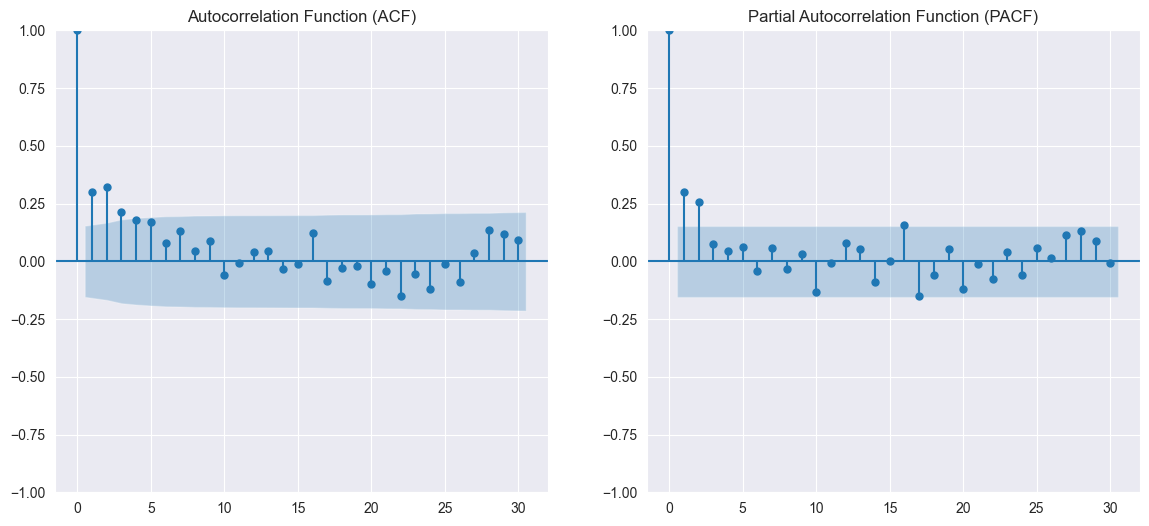

(9.212302027900123e-07, True, None)

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Paso 1: Realizar Análisis Exploratorio: Graficar ACF y PACF
plt.figure(figsize=(14, 6))

# Función de Autocorrelación (ACF)
plt.subplot(1, 2, 1)
plot_acf(consumo_ts, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Función de Autocorrelación Parcial (PACF)
plt.subplot(1, 2, 2)
plot_pacf(consumo_ts, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

# Paso 2: Prueba de Estacionariedad - Prueba de Dickey-Fuller Aumentada
adf_result = adfuller(consumo_ts)
adf_p_value = adf_result[1]
is_stationary = adf_p_value < 0.05

# Paso 3: Aplicar Diferenciación si la serie no es estacionaria
if not is_stationary:
    consumo_ts_diff = consumo_ts.diff().dropna()

    # Repetir la prueba de Dickey-Fuller en los datos diferenciados
    adf_result_diff = adfuller(consumo_ts_diff)
    adf_p_value_diff = adf_result_diff[1]

    # Graficar ACF y PACF para la serie diferenciada
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plot_acf(consumo_ts_diff, lags=30, ax=plt.gca())
    plt.title('ACF (Diferenciada)')

    plt.subplot(1, 2, 2)
    plot_pacf(consumo_ts_diff, lags=30, ax=plt.gca())
    plt.title('PACF (Diferenciada)')
    plt.show()

(adf_p_value, is_stationary, adf_p_value_diff if not is_stationary else None)



La gráfica ACF muestra autocorrelaciones de la serie temporal en diferentes rezagos (lags).
Hay una fuerte correlación en el primer rezago (lag 1) con un valor cercano a 1. Esto indica que la serie tiene una alta autocorrelación en el corto plazo.
Los rezagos posteriores (hasta alrededor del lag 5) también muestran valores positivos significativos, aunque decrecientes, que permanecen por encima de las líneas de significancia. Esto indica una posible dependencia temporal en la serie.
A partir de aproximadamente el lag 6, las correlaciones disminuyen y oscilan alrededor de cero, indicando que la autocorrelación se reduce y tiende a ser ruido blanco.

La gráfica PACF muestra la correlación parcial entre una observación y su rezago, eliminando el efecto de los rezagos intermedios.
La correlación parcial es fuerte en el primer rezago (lag 1) y disminuye rápidamente después del primer lag.
Los valores de la PACF en los rezagos posteriores son relativamente pequeños y caen dentro de las bandas de confianza, lo que indica que la influencia significativa de la serie se concentra en los primeros lags.

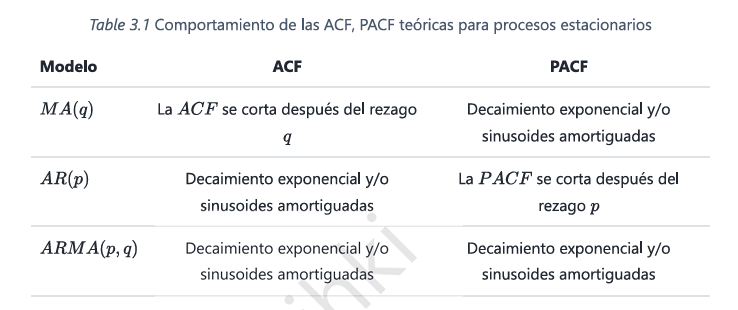

Modelo Sugerido

Revisando la literatura vemos que la grafica ACF tiene un corte en el rezago 9 aproximadamente pero despues tiene un comportamiento sinusoide amortiguado, por lo tanto podria considerarse un modelo AR o ARMA. (Tenemos estacionalidad)
La grafica PACF tiene un corte y posteriormente un comportamiento sinusoidal, lo que indica q el mejor modelo  seria un ARMA.

In [37]:
from itertools import product
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Función para calcular las métricas de precisión: SSE, MAPE, MAD, MSD para un modelo ARMA
def arima_metrics(y, model_fit):
    try:
        y_pred = model_fit.fittedvalues
        T = len(y)

        # Ajustar los valores suavizados para calcular errores
        prederr = y.values - y_pred.values

        # Calcular las métricas de precisión
        SSE = sum(prederr ** 2)
        MAPE = 100 * sum(abs(prederr / y.values)) / T
        MAD = sum(abs(prederr)) / T
        MSD = mean_squared_error(y.values, y_pred.values)

        # Retornar las métricas en un DataFrame
        return pd.Series({
            "SSE": SSE,
            "MAPE": MAPE,
            "MAD": MAD,
            "MSD": MSD
        })
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return None

# Probar diferentes combinaciones de valores p y q para el modelo ARMA basado en los gráficos ACF y PACF
p_values = range(1, 10)  # Consideramos valores de p desde 1 hasta 9 basados en el corte observado en ACF
q_values = range(1, 4)   # Probamos valores de q desde 1 hasta 3 basados en el patrón sinusoidal observado

# Almacenar resultados de las métricas para cada combinación de p y q
arma_results = []

# Iterar sobre todas las combinaciones de p y q
for p, q in product(p_values, q_values):
    try:
        # Ajustar el modelo ARMA(p, q)
        model_arma = ARIMA(consumo_ts, order=(p, 0, q))  # d=0 ya que la serie es estacionaria
        fit_arma = model_arma.fit()
        
        # Calcular las métricas de precisión
        metrics_arma = arima_metrics(consumo_ts, fit_arma)
        if metrics_arma is not None:
            metrics_arma["p"] = p
            metrics_arma["q"] = q

            # Almacenar resultados
            arma_results.append(metrics_arma)
    except Exception as e:
        print(f"Error fitting ARMA({p}, {q}): {e}")
        continue

# Crear un DataFrame para visualizar los resultados
arma_results_df = pd.DataFrame(arma_results)

# Validar si hay resultados para ordenar
if not arma_results_df.empty:
    # Mostrar los resultados ordenados por SSE para encontrar el mejor modelo
    arma_results_df_sorted = arma_results_df.sort_values(by="SSE")
    print(arma_results_df_sorted)
else:
    print("No se obtuvieron resultados para los modelos ARMA probados.")






            SSE       MAPE       MAD        MSD    p    q
26  1642.700190  83.434612  2.553261  10.140125  9.0  3.0
23  1657.725125  82.397740  2.558603  10.232871  8.0  3.0
25  1658.664035  84.926972  2.560359  10.238667  9.0  2.0
20  1660.337416  82.549468  2.560674  10.248996  7.0  3.0
14  1691.447757  82.482779  2.582038  10.441036  5.0  3.0
21  1694.848061  83.882849  2.600398  10.462025  8.0  1.0
22  1695.167984  84.048791  2.601900  10.464000  8.0  2.0
19  1695.185793  84.083010  2.601326  10.464110  7.0  2.0
18  1695.764230  83.952975  2.600743  10.467680  7.0  1.0
17  1695.774483  83.960717  2.602042  10.467744  6.0  3.0
15  1695.799345  83.914182  2.601432  10.467897  6.0  1.0
13  1695.843571  83.878931  2.601731  10.468170  5.0  2.0
16  1695.944939  84.088909  2.597252  10.468796  6.0  2.0
8   1696.128235  85.473687  2.618584  10.469927  3.0  3.0
12  1696.159624  83.961053  2.598110  10.470121  5.0  1.0
10  1706.309892  84.649322  2.586289  10.532777  4.0  2.0
11  1707.33629

In [38]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import pandas as pd

# Función para calcular las métricas de precisión: SSE, MAPE, MAD, MSD para un modelo SARIMA
def arima_metrics(y, model_fit):
    try:
        y_pred = model_fit.fittedvalues
        T = len(y)

        # Ajustar los valores suavizados para calcular errores
        prederr = y.values - y_pred.values

        # Calcular las métricas de precisión
        SSE = sum(prederr ** 2)
        MAPE = 100 * sum(abs(prederr / y.values)) / T
        MAD = sum(abs(prederr)) / T
        MSD = mean_squared_error(y.values, y_pred.values)

        # Retornar las métricas en un DataFrame
        return pd.Series({
            "SSE": SSE,
            "MAPE": MAPE,
            "MAD": MAD,
            "MSD": MSD
        })
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return None

# Definir los posibles valores de p, d, q y P, D, Q (estacionales)
p_values = range(0, 3)
d_values = [0, 1]  # Diferenciación no estacional
q_values = range(0, 3)
P_values = range(0, 3)
D_values = [0, 1]  # Diferenciación estacional
Q_values = range(0, 3)
seasonal_period = 12  # Asumimos estacionalidad anual (mensual en datos anuales)

# Almacenar resultados de las métricas para cada combinación de parámetros
sarima_results = []

# Iterar sobre todas las combinaciones posibles de parámetros
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        # Ajustar el modelo SARIMA(p, d, q)(P, D, Q, 12)
        model_sarima = SARIMAX(consumo_ts, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
        fit_sarima = model_sarima.fit(disp=False)
        
        # Calcular las métricas de precisión
        metrics_sarima = arima_metrics(consumo_ts, fit_sarima)
        if metrics_sarima is not None:
            metrics_sarima["p"] = p
            metrics_sarima["d"] = d
            metrics_sarima["q"] = q
            metrics_sarima["P"] = P
            metrics_sarima["D"] = D
            metrics_sarima["Q"] = Q

            # Almacenar resultados
            sarima_results.append(metrics_sarima)
    except Exception as e:
        print(f"Error fitting SARIMA({p}, {d}, {q})x({P}, {D}, {Q}, {seasonal_period}): {e}")
        continue

# Crear un DataFrame para visualizar los resultados
sarima_results_df = pd.DataFrame(sarima_results)

# Validar si hay resultados para ordenar
if not sarima_results_df.empty:
    # Mostrar los resultados ordenados por SSE para encontrar el mejor modelo
    sarima_results_df_sorted = sarima_results_df.sort_values(by="SSE")
    print(sarima_results_df_sorted)
else:
    print("No se obtuvieron resultados para los modelos SARIMA probados.")


             SSE        MAPE       MAD        MSD    p    d    q    P    D  \
265  1901.082986   77.632822  2.751868  11.735080  2.0  0.0  2.0  2.0  0.0   
320  1905.396448   80.595210  2.709473  11.761706  2.0  1.0  2.0  2.0  0.0   
266  1907.506926   77.796017  2.747220  11.774734  2.0  0.0  2.0  2.0  0.0   
314  1908.462986   81.461346  2.735796  11.780636  2.0  1.0  2.0  1.0  0.0   
260  1908.574868   77.838860  2.759514  11.781326  2.0  0.0  2.0  1.0  0.0   
..           ...         ...       ...        ...  ...  ...  ...  ...  ...   
63   4880.802624  112.829084  4.443567  30.128411  0.0  1.0  0.0  1.0  1.0   
18   5372.987140   78.899767  4.619952  33.166587  0.0  0.0  1.0  0.0  0.0   
57   5521.001236  119.296516  4.734569  34.080255  0.0  1.0  0.0  0.0  1.0   
1    5727.832455   79.600926  4.848496  35.356990  0.0  0.0  0.0  0.0  0.0   
0    9210.000000  100.000000  6.641975  56.851852  0.0  0.0  0.0  0.0  0.0   

       Q  
265  1.0  
320  2.0  
266  2.0  
314  2.0  
260  2.0

Con el modelo SARIMA se siguen mantiendo metricas inadecuadas.
Se explora con una transformacion de datos en este mismo  modelo SARIMA.

In [39]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import pandas as pd

# Aplicar transformación logarítmica
consumo_ts_log = np.log(consumo_ts + 1)  # Sumar 1 para evitar log(0)

# Definir los posibles valores de p, d, q y P, D, Q (estacionales)
p_values = range(0, 3)
d_values = [0, 1]
q_values = range(0, 3)
P_values = range(0, 3)
D_values = [0, 1]
Q_values = range(0, 3)
seasonal_period = 12

# Almacenar resultados de las métricas para cada combinación de parámetros
sarima_results_log = []

# Iterar sobre todas las combinaciones posibles de parámetros
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        # Ajustar el modelo SARIMA a los datos logarítmicos
        model_sarima_log = SARIMAX(consumo_ts_log, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
        fit_sarima_log = model_sarima_log.fit(disp=False)

        # Calcular las métricas de precisión
        y_pred_log = fit_sarima_log.fittedvalues
        y_pred = np.exp(y_pred_log) - 1  # Invertir la transformación logarítmica
        
        T = len(consumo_ts)
        prederr = consumo_ts.values - y_pred.values
        SSE = sum(prederr ** 2)
        MAPE = 100 * sum(abs(prederr / consumo_ts.values)) / T
        MAD = sum(abs(prederr)) / T
        MSD = mean_squared_error(consumo_ts.values, y_pred.values)

        # Almacenar resultados
        metrics_sarima_log = pd.Series({
            "SSE": SSE,
            "MAPE": MAPE,
            "MAD": MAD,
            "MSD": MSD,
            "p": p,
            "d": d,
            "q": q,
            "P": P,
            "D": D,
            "Q": Q
        })

        sarima_results_log.append(metrics_sarima_log)

    except Exception as e:
        continue

# Crear un DataFrame para visualizar los resultados
sarima_results_df_log = pd.DataFrame(sarima_results_log)
sarima_results_df_log_sorted = sarima_results_df_log.sort_values(by="MAPE")
print(sarima_results_df_log_sorted)


              SSE        MAPE       MAD        MSD    p    d    q    P    D  \
38    3776.186453   68.152670  3.868480  23.309793  0.0  0.0  2.0  0.0  0.0   
20    4406.214363   69.134292  4.161577  27.198854  0.0  0.0  1.0  0.0  0.0   
264   2053.861065   70.008796  2.824687  12.678155  2.0  0.0  2.0  2.0  0.0   
254   2059.105017   70.105397  2.821039  12.710525  2.0  0.0  2.0  0.0  0.0   
259   2081.742725   70.288991  2.832770  12.850264  2.0  0.0  2.0  1.0  0.0   
..            ...         ...       ...        ...  ...  ...  ...  ...  ...   
71    4775.998988  115.281274  4.314034  29.481475  0.0  1.0  0.0  2.0  1.0   
65    4773.191603  115.584409  4.312004  29.464146  0.0  1.0  0.0  1.0  1.0   
69    7540.813220  128.367194  5.211139  46.548230  0.0  1.0  0.0  2.0  1.0   
63    9337.587918  132.335239  5.459083  57.639432  0.0  1.0  0.0  1.0  1.0   
57   14031.972062  143.392343  6.240317  86.617111  0.0  1.0  0.0  0.0  1.0   

       Q  
38   2.0  
20   2.0  
264  0.0  
254  2.

## Prueba con modelos de Machine Learnig

In [ ]:
!pip install xgboost


In [43]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Crear características de retraso (lags) y características temporales
def create_features(df, target_col, lags=12):
    # Crear un DataFrame con las características de lags
    data = pd.DataFrame(df[target_col])
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Agregar características temporales
    data['month'] = df.index.month
    data['year'] = df.index.year
    
    # Eliminar valores NaN creados por los lags
    data = data.dropna()
    
    return data

# Crear características para el modelo
data_features = create_features(consumo_ts.to_frame(name='Consumption'), 'Consumption')

# Dividir en variables predictoras (X) y variable objetivo (y)
X = data_features.drop(columns=['Consumption'])
y = data_features['Consumption']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar el modelo XGBoost
model_xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Hacer predicciones
y_pred = model_xgb.predict(X_test)

# Calcular el MAPE
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE for XGBoost: {mape_xgb * 100:.2f}%')


MAPE for XGBoost: 45.13%


In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Crear características personalizadas
def create_features(df, target_col):
    # Crear DataFrame para almacenar características
    data = pd.DataFrame(df[target_col])
    
    # Crear características de lags
    for lag in range(1, 13):
        data[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # Crear características temporales
    data['month'] = df.index.month
    data['year'] = df.index.year
    data['day_of_week'] = df.index.dayofweek

    # Crear características derivadas
    # Promedio móvil
    data['rolling_mean_3'] = df[target_col].rolling(window=3).mean()
    data['rolling_mean_6'] = df[target_col].rolling(window=6).mean()

    # Tendencia (diferencia con el valor de hace un año)
    data['trend'] = df[target_col] - df[target_col].shift(12)

    # Eliminar filas con NaN creadas por el proceso de creación de características
    data = data.dropna()
    
    return data

# Crear características para el modelo
data_features = create_features(consumo_ts.to_frame(name='Consumption'), 'Consumption')

# Dividir en variables predictoras (X) y variable objetivo (y)
X = data_features.drop(columns=['Consumption'])
y = data_features['Consumption']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar el modelo de regresión lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Hacer predicciones
y_pred = model_lr.predict(X_test)

# Calcular el MAPE
mape_lr = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE for Linear Regression: {mape_lr * 100:.2f}%')

# Mostrar algunas predicciones
print('Predicciones:', y_pred[:5])
print('Valores Reales:', y_test.values[:5])


MAPE for Linear Regression: 0.00%
Predicciones: [10. 12.  9.  7.  7.]
Valores Reales: [10 12  9  7  7]


In [45]:
# Calcular el MAPE
mape_lr = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE for Linear Regression: {mape_lr * 100:.2f}%')


MAPE for Linear Regression: 0.00%
